In [2]:
import author
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.linear_model import Ridge,Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import sys
sys.path.insert(0, "/Users/jin/Programming/Machine_Learning/All-about-Market/trading/Jeong/machine_trade/code")
import eval_model
engine = author.processed_engine

2015년부터 5년간 장기 채권의 가격과 연관된 정보들을 가져온다.

gap은 그날의 (고가 - 종가) / 시초가 로 변동성을 확인 하기 위한 지표이다.</br>
나머지 지표들은 말 그대로를 의미한다.

In [3]:
df = pd.read_sql("SELECT * FROM TLT_1d",engine) #로컬 db에서 테이블 가져옴
df.set_index(df.columns[0], inplace=True)
df

,Price,Gap,Rsi,Macd,Macd_Signal,Vwap,Volume,Fast_k,Fast_d,Moment,Pct
time,,,,,,,,,,,
2015-09-17,104.537,0.014,45.341,-0.186,-0.503,118.912,2.204,-288.482,-280.790,0.979,1.220
2015-09-18,106.145,0.009,52.208,-0.225,-0.380,118.891,1.485,-304.574,-288.718,0.987,1.538
2015-09-21,104.415,0.011,45.575,-0.263,-0.418,118.868,0.956,-350.800,-309.412,0.979,-1.630
2015-09-22,105.867,0.010,51.181,-0.276,-0.326,118.854,0.895,-348.704,-322.510,0.986,1.390
2015-09-23,105.858,0.009,51.147,-0.271,-0.252,118.844,0.589,-345.477,-330.166,0.986,-0.008
...,...,...,...,...,...,...,...,...,...,...,...
2022-04-01,132.380,0.025,46.961,-2.070,-1.743,133.685,1.179,45.331,21.382,1.093,0.381
2022-04-04,131.460,0.010,44.608,-1.981,-1.622,133.683,0.701,12.733,18.499,1.089,-0.695
2022-04-05,128.490,0.019,37.991,-1.934,-1.746,133.677,1.302,3.396,13.465,1.078,-2.259


In [4]:
df.describe()

,Price,Gap,Rsi,Macd,Macd_Signal,Vwap,Volume,Fast_k,Fast_d,Moment,Pct
count,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000
mean,128.061183,0.008239,51.161918,0.121396,0.116886,123.953495,1.008573,-137.655354,-138.007595,1.091771,0.016186
std,18.017274,0.006390,11.143944,1.123535,1.185496,4.690475,0.335655,125.489862,122.484108,0.085588,0.884420
min,103.306000,0.002000,17.978000,-2.956000,-3.163000,118.341000,0.305000,-542.251000,-512.600000,0.972000,-6.668000
25%,113.173250,0.005000,43.541000,-0.462250,-0.551000,120.780500,0.780000,-235.330500,-236.020000,1.021000,-0.479250
50%,119.937000,0.007000,51.439500,0.148000,0.149500,121.490000,0.949500,-129.338000,-131.071000,1.062000,0.046000
75%,142.230000,0.010000,58.437250,0.651500,0.659750,128.028250,1.184250,-17.971750,-17.468750,1.159000,0.509000
max,169.314000,0.109000,86.259000,4.351000,5.565000,133.730000,2.822000,45.331000,23.832000,1.285000,7.520000


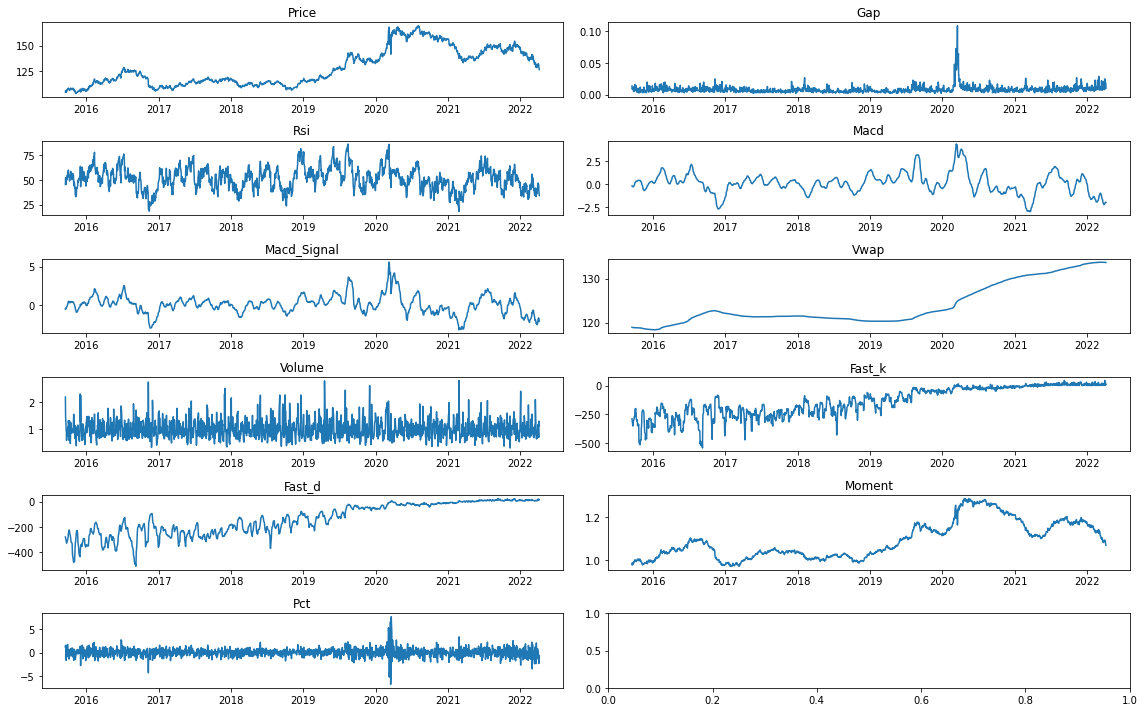

In [5]:
get_rows = lambda x: x // 2 if x % 2 == 0 else x // 2 +1 #행의 수를 결정한다.
rows = get_rows(len(df.columns))
fig, axes = plt.subplots(rows, 2, figsize=(16,10))
for i, c in enumerate(df.columns, start=1):
        plt.subplot(len(df.columns) // 2 + 1,2,i)
        plt.plot(df[c])
        plt.title(c)
plt.tight_layout()

volume은 시간이 지남에 따라 상승하는 경향이 보이므로 이동평균을 통해 나눠준 값을 사용한다.</br>
거래량 = (거래량 / 지난 7일간의 이동 평균 거래량) 평균적인 거래량에 비해 얼마나 더 많이 거래가 발생했는지 확인 가능하다.</br>
가격 역시 시간이 지남에 따라 자연히 증가하므로 전일 대비 증감률을 사용한다.

이렇게 데이터를 변형해 줌으로써 모델은 가격이 시간이 지남에 따라 자연히 증가하는 것이 아니라 학습 할 수 있다. </br>

In [6]:
volume_mva = df['Volume'].rolling(window = 7).mean()
df['Volume'] = df['Volume'] / volume_mva
df['Pct'] = df['Price'].pct_change() * 100
df = df.apply(lambda x: x.round(3)) #적당히 값을 묶어주기 위해 소수점 3자리를 기점으로 반올림을 진행한다.
df = df.dropna() #결측치를 제거해준다.
df

,Price,Gap,Rsi,Macd,Macd_Signal,Vwap,Volume,Fast_k,Fast_d,Moment,Pct
time,,,,,,,,,,,
2015-09-25,105.658,0.005,50.029,-0.217,-0.112,118.825,0.668,-304.324,-317.103,0.986,-0.865
2015-09-28,107.466,0.013,56.590,-0.164,0.050,118.819,1.063,-282.254,-305.486,0.995,1.711
2015-09-29,107.771,0.008,57.598,-0.091,0.201,118.818,1.152,-269.676,-293.550,0.997,0.284
2015-09-30,107.397,0.006,55.880,-0.015,0.287,118.814,1.237,-273.924,-287.008,0.996,-0.347
2015-10-01,107.855,0.007,57.552,0.065,0.387,118.813,1.135,-264.741,-279.586,0.998,0.426
...,...,...,...,...,...,...,...,...,...,...,...
2022-04-01,132.380,0.025,46.961,-2.070,-1.743,133.685,1.334,45.331,21.382,1.093,0.381
2022-04-04,131.460,0.010,44.608,-1.981,-1.622,133.683,0.785,12.733,18.499,1.089,-0.695
2022-04-05,128.490,0.019,37.991,-1.934,-1.746,133.677,1.383,3.396,13.465,1.078,-2.259


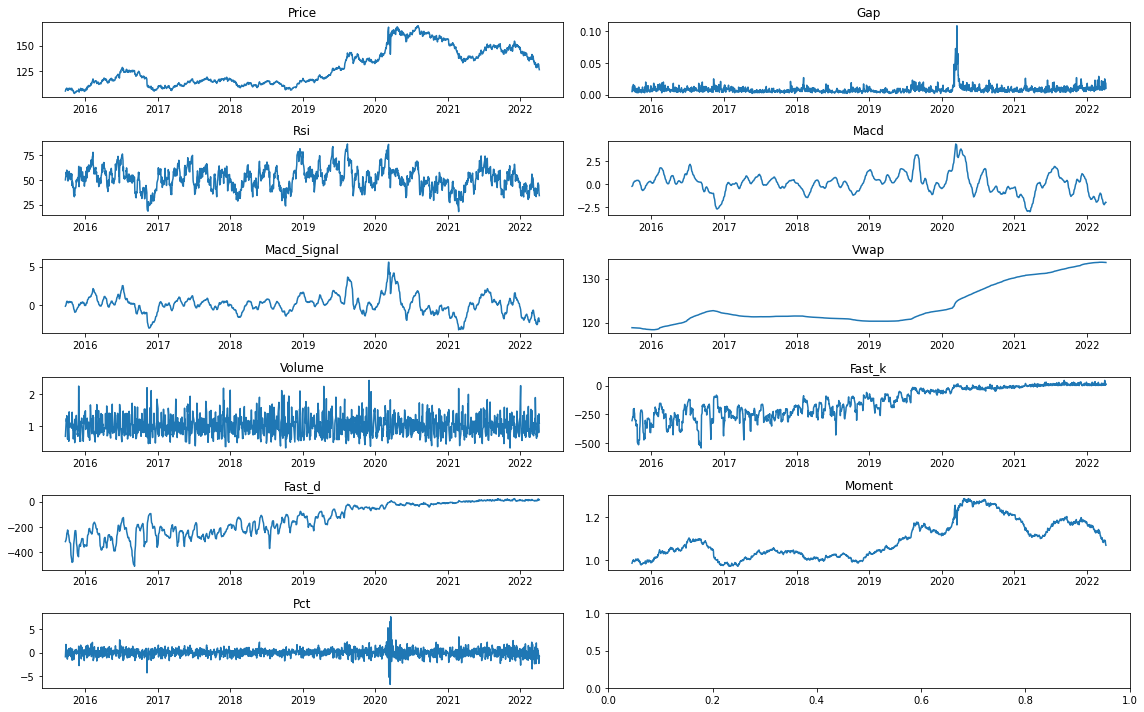

In [7]:
fig, axes = plt.subplots(rows, 2, figsize=(16,10))
for i, c in enumerate(df.columns,start=1):
        plt.subplot(rows, 2, i)
        plt.plot(df[c])
        plt.title(c)
plt.tight_layout()

Volume과 Pct를 보면 동일하게 거래량과 가격에 관한 지표를 나타내지만, 선형성이 사라진 것을 확인 할 수 있다. </br>
이제 모델은 무작정 시간이 지남에 따라 값이 증가한다고 예측하지 못한다.

<AxesSubplot:>

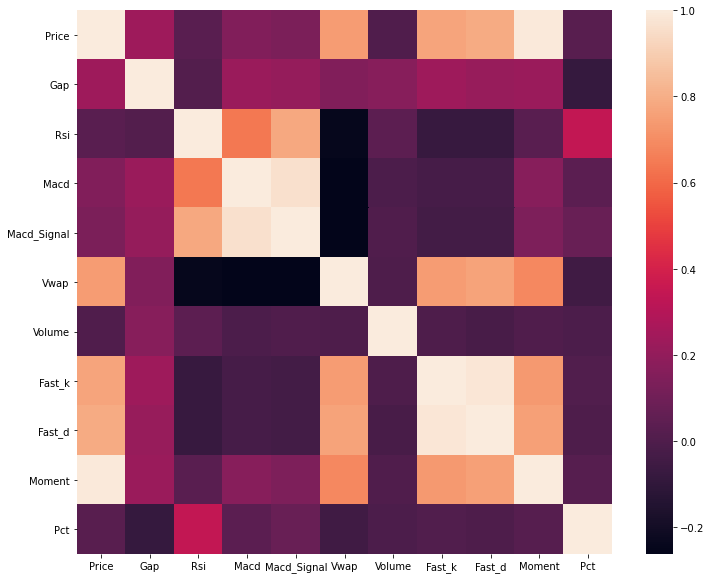

In [8]:
corr = df.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr)

In [9]:
corr[corr.abs() > 0.3]

,Price,Gap,Rsi,Macd,Macd_Signal,Vwap,Volume,Fast_k,Fast_d,Moment,Pct
Price,1.000000,NaN,NaN,NaN,NaN,0.747615,NaN,0.770907,0.790764,0.990943,NaN
Gap,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rsi,NaN,NaN,1.000000,0.644519,0.779224,NaN,NaN,NaN,NaN,NaN,0.342486
Macd,NaN,NaN,0.644519,1.000000,0.961616,NaN,NaN,NaN,NaN,NaN,NaN
Macd_Signal,NaN,NaN,0.779224,0.961616,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
Vwap,0.747615,NaN,NaN,NaN,NaN,1.000000,NaN,0.747927,0.767496,0.687222,NaN
Volume,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
Fast_k,0.770907,NaN,NaN,NaN,NaN,0.747927,NaN,1.000000,0.984157,0.735351,NaN
Fast_d,0.790764,NaN,NaN,NaN,NaN,0.767496,NaN,0.984157,1.000000,0.754097,NaN
Moment,0.990943,NaN,NaN,NaN,NaN,0.687222,NaN,0.735351,0.754097,1.000000,NaN


Price는 Fask_k,vwap 와 깊은 상관성을 보인다.</br>

RSI와 가격 증감률 간의 상관 관계를 나타내보면 다음과 같다. </br>
어느 정도의 양의 상관 관계를 갖는 것이 보인다.

In [10]:
def plot_corr(x, y, x_name = 'X_feature', y_name = 'y_feature'):
    plt.figure(figsize=(10,10))
    x = (x - x.min()) / (x.max() - x.min())
    y = (y - y.min()) / (y.max() - y.min())
    plt.scatter(x=x, y=y)
    plt.xlabel(x_name)
    plt.ylabel(y_name)

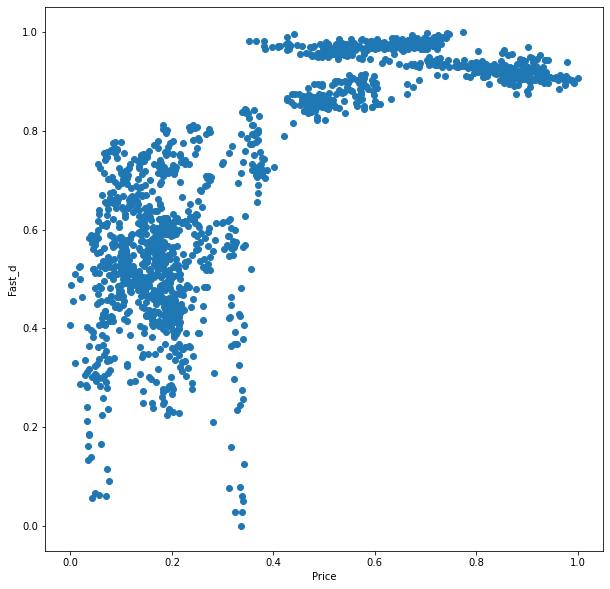

In [11]:
plot_corr(x=df['Price'], y=df['Fast_d'], x_name="Price",y_name="Fast_d")

VWAP와 가격의 상관 관계
* 강한 양의 상관 관계를 띄지만 파악이 불가한 부분이 존재한다.

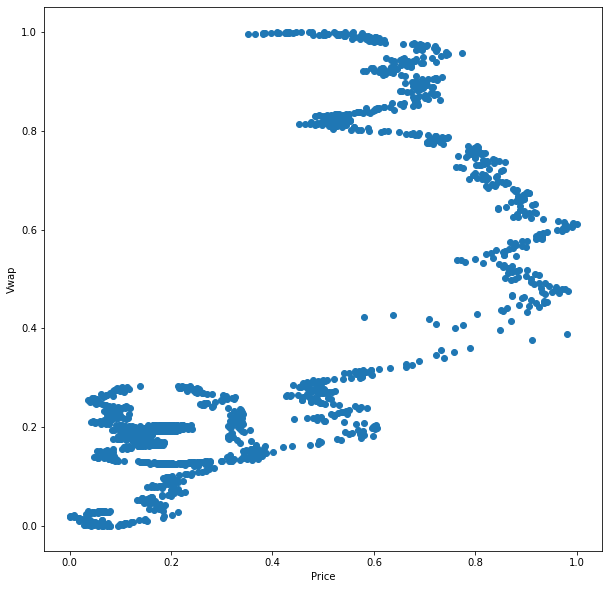

In [12]:
plot_corr(x=df['Price'], y=df['Vwap'], x_name="Price", y_name="Vwap")

#### MACD와 가격 증감률 간의 관계를 살펴보자.

MACD는 이평선의 수렴과 발산을 통해 과매수, 과매도를 보여주는 지표이다. 일반적으로 시그널선의 아래에 위치하면 과매도, 시그널 선의 위편에 위치하면 과매수 상태로 여긴다.


In [14]:
def get_cross(graph1, graph2):
    """ 특정한 그래프 2개를 입력받고 
    그래프가 교차되는 지점을 구해줍니다"""
    gap = graph1 - graph2
    buy_sign = []
    sell_sign = []
    for i, g in enumerate(gap.values[1:], start=1):
        if g * gap[i - 1] < 0:
            if g > 0: #차이가 양으로 전환되면 과매수이므로 매도 시그널이다.
                buy_sign.append(gap.index[i]) 
            else:
                sell_sign.append(gap.index[i])
    return buy_sign, sell_sign

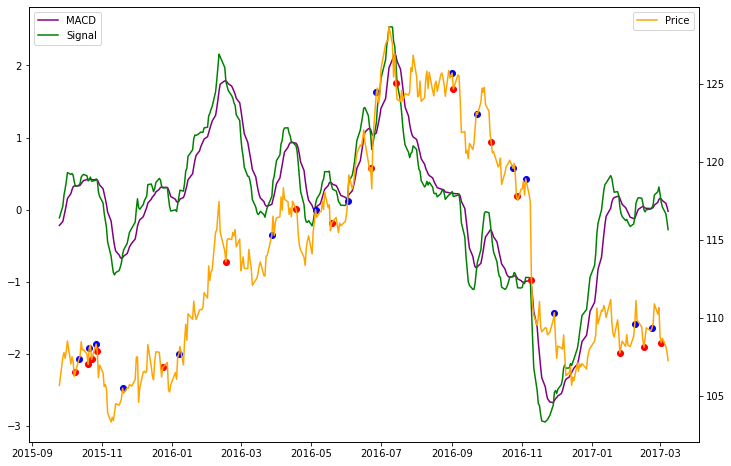

In [15]:
YEAR = 365
fig,ax1 = plt.subplots(figsize=(12,8))
macd_year, signal_year = df['Macd'].iloc[:YEAR], df['Macd_Signal'].iloc[:YEAR]
buy_point, sell_point = get_cross(macd_year, signal_year)
price = df['Price'].iloc[:YEAR]

ax1.plot(macd_year, label='MACD', color='purple')
ax1.plot(signal_year, label='Signal', color='green')
plt.legend(loc="upper left")


ax2 = ax1.twinx()
ax2.plot(price[:365],color='orange',label='Price')
ax2.scatter(buy_point, price.loc[buy_point], marker='o', color='red')
ax2.scatter(sell_point, price.loc[sell_point], marker='o', color='blue')

plt.legend(loc="upper right")

* MACD는 이동평균이라는 정보에 걸맞게 가격의 변동을 원만한 기울기로 추종하고 있다는 것을 확인 할 수 있다. </br>
* Signal과 교차되는 전략을 생각해보면 훌륭하게 들어 맞는다고 볼 수는 없을 것 같다. (빨강: 매수, 파랑: 매도)</br>


* 피쳐의 관점에선 MACD와 MACD 시그널은 실상 같은 움직임을 보이므로</br>
둘중 하나의 피쳐만 사용하는 쪽이 더 나을 듯 하다. </br>
아니면 시그널과 MACD의 격차만을 피쳐로 사용하는 것도 괜찮아 보인다.

#### 스토캐스틱 지표의 상관관계

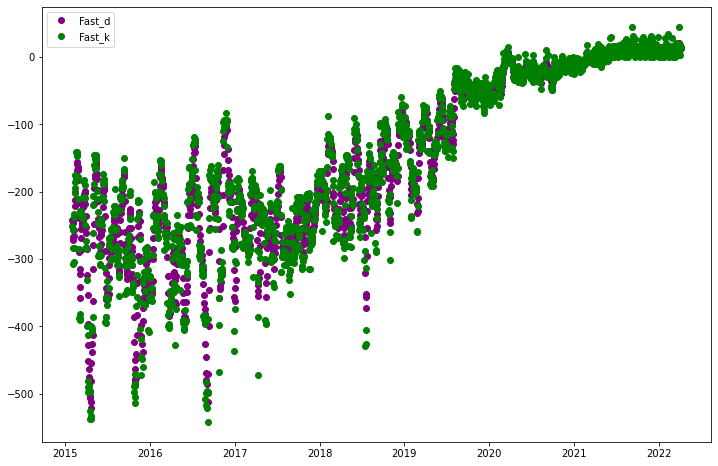

In [28]:
plt.figure(figsize=(12,8))
plt.plot(df['Fast_d'], label='Fast_d', color='purple',linestyle='None',marker='o')
plt.plot(df['Fast_k'], label='Fast_k', color='green',linestyle='None',marker='o')
plt.legend()

Fast_d는 Fast_k를 또 다시 이동평균을 내 활용한 지표이다 보니 값이 전반적으로 안정적이고 극렬하게 튀는 현상이 덜하다.</br>
Fast_k가 가격 증감률과의 상관관계도 더 높지만, 과하게 상태 변화를 받아들이는 값이라는 점에서 </br>
Fast_k보다 Fast_d를 사용하는 쪽이 유리해 보인다.</br>
Fast_k, Fast_d는 상관 계수가 0.7을 넘어가기에 하나만 사용한다.

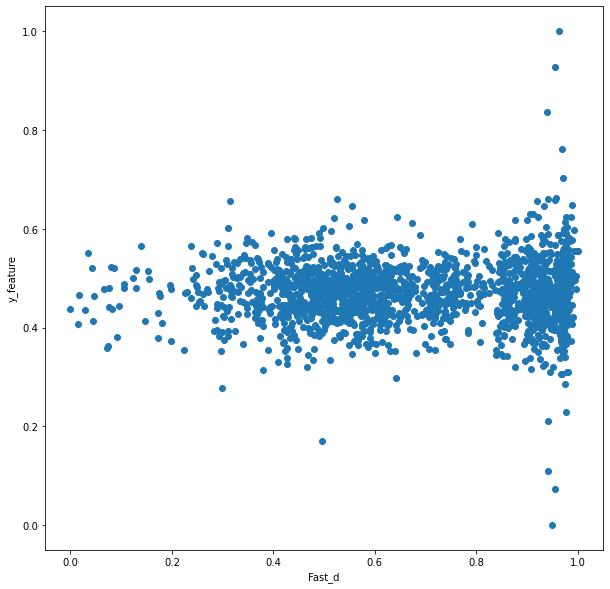

In [29]:
plot_corr(x=df['Fast_d'], y=df['Pct'],x_name="Fast_d")

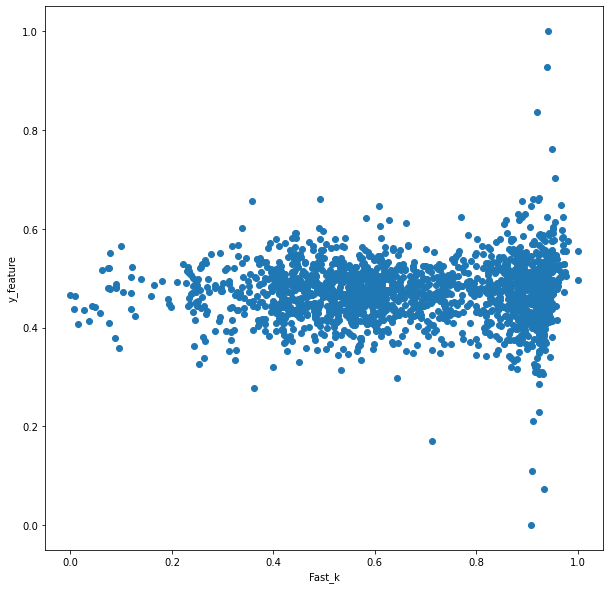

In [30]:
plot_corr(x=df['Fast_k'],y=df['Pct'],x_name="Fast_k")

#### 피쳐 선택
다음과 같은 피쳐를 제외하고 모델을 학습 시키기로 했다.
* Gap: 대신 가격 증감률을 사용하기로 했다.
* Macd, Macd_Signal: 대신 시그널 - MACD를 사용한다.
* Fast_k: 대신 Fast_d를 사용한다.

In [31]:
macd_gap = df['Macd_Signal'] - df['Macd']
new_df = df
# new_df = df.drop(["Macd","Fast_k","Volume","Gap"], axis=1)
new_df["Macd_Gap"] = macd_gap
new_df

,Price,Gap,Rsi,Macd,Macd_Signal,Vwap,Volume,Fast_k,Fast_d,Pct,Macd_Gap
time,,,,,,,,,,,
2015-01-30,118.207,0.010,72.837,1.754,2.019,126.464,1.541,-250.308,-241.265,1.774,0.265
2015-02-02,117.760,0.009,70.101,1.820,2.081,126.736,1.349,-256.788,-246.440,-0.378,0.261
2015-02-03,115.268,0.011,57.178,1.837,1.906,126.842,1.262,-307.109,-266.665,-2.117,0.069
2015-02-04,115.465,0.014,57.839,1.822,1.764,126.890,0.957,-283.845,-272.392,0.171,-0.058
2015-02-05,114.197,0.008,52.246,1.764,1.531,126.899,0.700,-304.066,-282.950,-1.098,-0.233
...,...,...,...,...,...,...,...,...,...,...,...
2022-04-01,132.380,0.025,46.961,-2.070,-1.743,133.685,1.179,45.331,21.382,0.381,0.327
2022-04-04,131.460,0.010,44.608,-1.981,-1.622,133.683,0.701,12.733,18.499,-0.695,0.359
2022-04-05,128.490,0.019,37.991,-1.934,-1.746,133.677,1.302,3.396,13.465,-2.259,0.188


#### 모멘텀 지표
* 추가적으로 특정 주기별 비트코인의 기하 평균 수익률을 기록하는 모멘텀 지표를 추가해준다.
* 모멘텀 지표를 통해 추세를 확인 할 수 있다.

In [32]:
def get_profit(X):
    """수익률을 구해준다."""
    seed = [1]
    for i, v in enumerate(X[1:], start=1):
        seed.append(seed[i - 1] * (1 + v))
    return seed

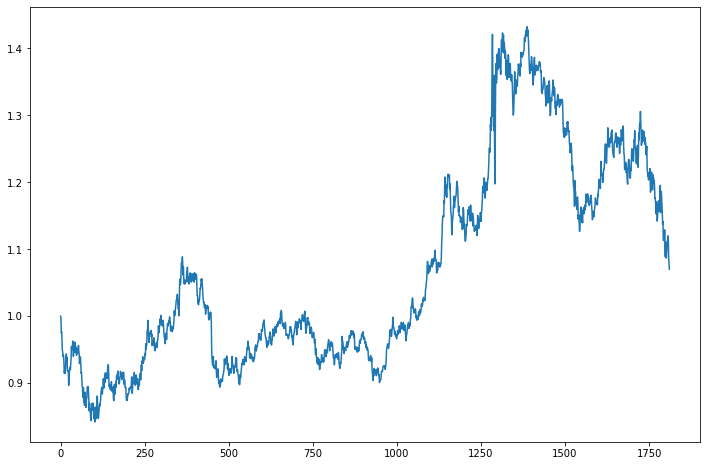

In [33]:
plt.figure(figsize=(12,8))
plt.plot(get_profit(new_df['Pct'] / 100))

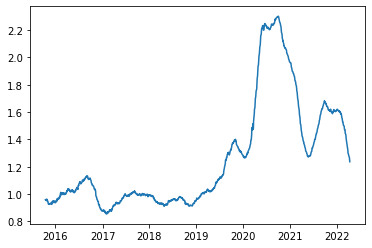

In [34]:
#수익 곡선을 그려보자 비트코인 그래프와 흡사하게 그려진다.
#모멘텀 팩터 만들기
profit = pd.Series(index=new_df.index, data=get_profit(new_df['Pct'] / 100)) #profit은 실제 내 수익률을 보여준다.
m2 = profit.rolling(60).apply(lambda x: x.prod() ** (1.0 / 14)) #2주 간의 기하 평균 수익률
m3 = profit / profit.rolling(90).apply(lambda x: x.prod() ** (1.0 / 30)) #1달 간의 기하 평균 수익률
m6 = profit / profit.rolling(180).apply(lambda x: x.prod() ** (1.0 / 60)) #2달 간의 기하 평균 수익률
momentum = (m2 * 0.5 + m3 * 0.3 + m6 * 0.2).dropna()
plt.plot(momentum)

* 모멘텀 지표는 실제 수익률 그래프와 비교했을 때 평균을 활용하기에 훨씬 부드럽고 </br>
전반적인 추세 파악에 유용하다.

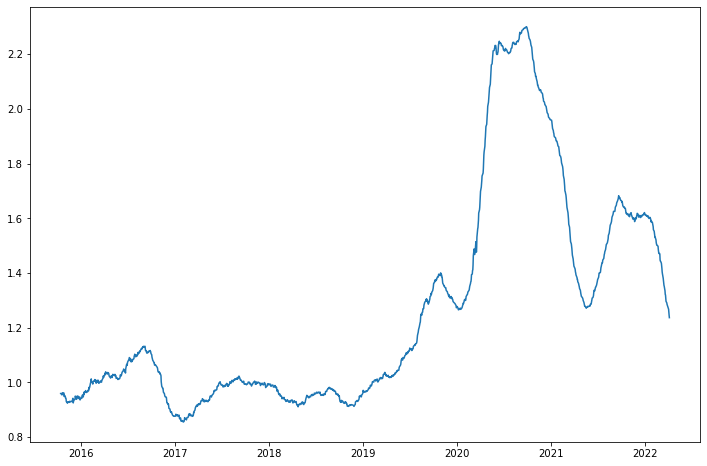

In [35]:
plt.figure(figsize=(12, 8))
plt.plot(momentum)

In [37]:
momentum.index = new_df.index[179:] #모멘텀 지표를 df에 추가해준다.
momentum.name = "Moment"
moment_df = new_df.join(momentum).dropna()
moment_df

,Price,Gap,Rsi,Macd,Macd_Signal,Vwap,Volume,Fast_k,Fast_d,Pct,Macd_Gap,Moment
time,,,,,,,,,,,,
2015-10-15,107.925,0.005,55.617,0.383,0.474,118.780,0.870,-348.469,-308.344,-0.490,0.091,0.959608
2015-10-16,107.960,0.005,55.776,0.404,0.489,118.780,0.988,-349.681,-322.123,0.032,0.085,0.959833
2015-10-19,107.663,0.009,54.008,0.418,0.471,118.778,0.867,-335.091,-326.446,-0.274,0.053,0.958290
2015-10-20,107.001,0.003,50.179,0.414,0.399,118.773,0.942,-341.730,-331.540,-0.615,-0.015,0.954338
2015-10-21,108.064,0.006,55.618,0.416,0.423,118.773,0.922,-338.592,-333.891,0.993,0.007,0.960842
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-01,132.380,0.025,46.961,-2.070,-1.743,133.685,1.179,45.331,21.382,0.381,0.327,1.275089
2022-04-04,131.460,0.010,44.608,-1.981,-1.622,133.683,0.701,12.733,18.499,-0.695,0.359,1.267912
2022-04-05,128.490,0.019,37.991,-1.934,-1.746,133.677,1.302,3.396,13.465,-2.259,0.188,1.254999


#### 이상치 확인 해보기
* iqr 범위를 벗어나는 데이터가 몇개 있는지 확인해보자. 
* gap, vwap, macd가 특히 심하다.


ValueError: num must be 1 <= num <= 10, not 11

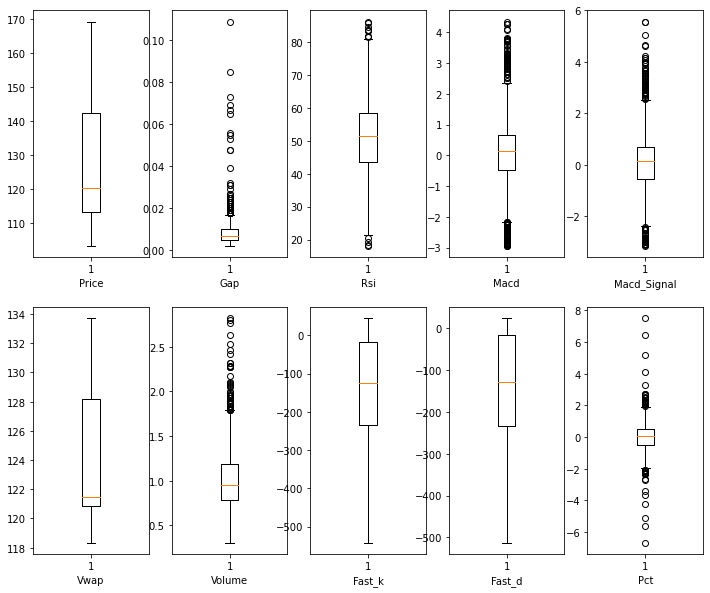

In [38]:
fig,axes = plt.subplots(2,5,figsize=(12,10))
for i, c in enumerate(moment_df.columns,start=1):
    plt.subplot(2,5,i)
    plt.boxplot(moment_df[c])
    plt.xlabel(c)
plt.tight_layout()

In [39]:
from collections import defaultdict
def get_outliers(df):
    """ 
        iqr 범위를 벗어나는 아웃 라이어들의 인덱스를 반환한다.
    """
    q_1 = df.apply(lambda x: np.quantile(x, 0.25))
    q_3 = df.apply(lambda x: np.quantile(x, 0.75))
    iqr = q_3 - q_1
    min_p = q_1 - 1.5 * iqr
    max_p = q_3 + 1.5 * iqr
    outliers = np.where((df < min_p) | (df > max_p))
    row, col = outliers
    outliers_loc = defaultdict(list)
    for r,c in zip(row,col):
        outliers_loc[df.columns[c]].append(r)
    return outliers_loc


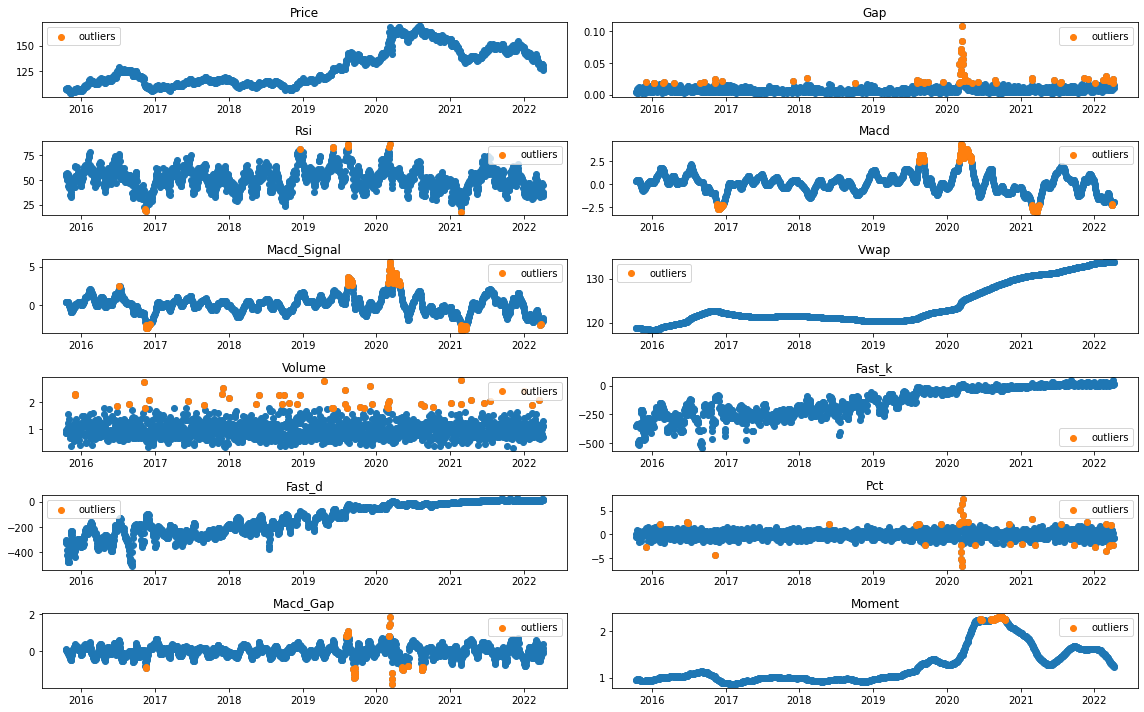

In [40]:
def draw_outlier(outliers_cols, df):
    """ 아웃 라이어들을 피쳐 별로 전부 그려 줍니다"""
    rows = get_rows(len(df.columns))
    fig, axes = plt.subplots(rows, 2, figsize=(16,10))
    for i, c in enumerate(df.columns,start=1):
        index = df[c].index
        plt.subplot(rows,2,i)
        plt.title(c)
        plt.scatter(x=index,y=df[c])
        plt.scatter(x=df[c].iloc[outliers_cols[c]].index, y=df[c].iloc[outliers_cols[c]],label='outliers')
        plt.legend()
    plt.tight_layout()

outliers_cols = get_outliers(moment_df)
draw_outlier(outliers_cols, moment_df)

피쳐별로 아웃라이어를 모조리 제거해 주기에는 문제가 있다. </br>
RSI에서 잡힌 아웃라이어 정도만 제거해준다.

In [41]:
for k, v in outliers_cols.items():
    print(f"{k}: {len(v)}")

Volume: 46
Gap: 62
Pct: 42
Macd_Signal: 96
Rsi: 12
Macd_Gap: 39
Macd: 111
Moment: 51
Price: 0
Vwap: 0
Fast_k: 0
Fast_d: 0


<AxesSubplot:>

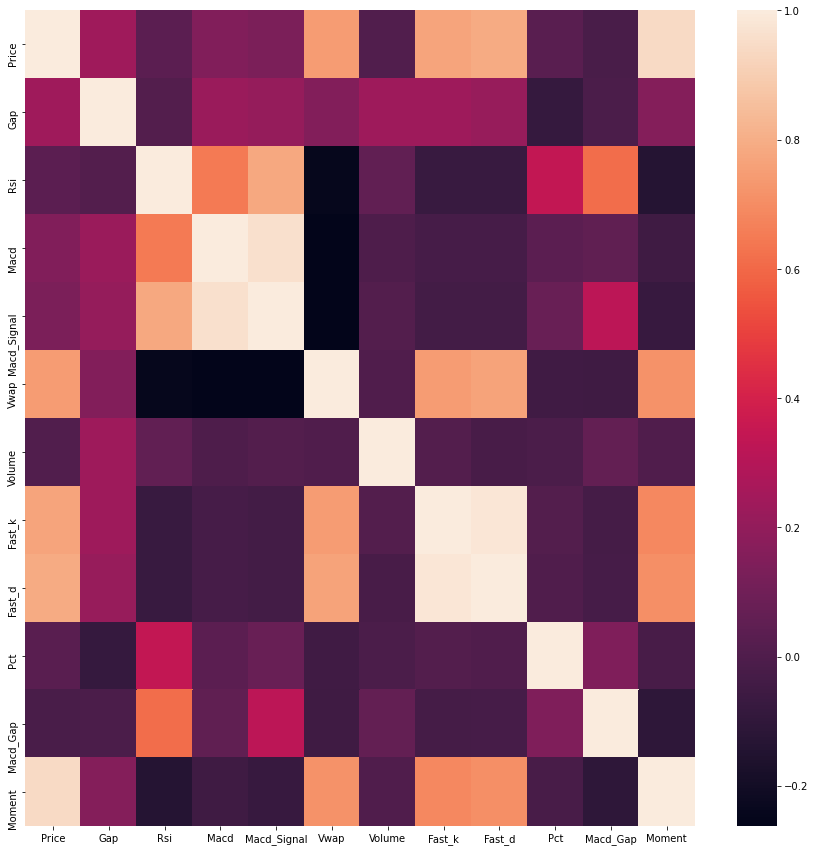

In [42]:
corr = moment_df.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr)

모멘트 팩터는 큰 연관성은 없어 보이지만, 전반적인 수익률 곡선의 추세를 보여주기에 사용했다.</br>
기존에 존재하는 듀얼 모멘텀 전략 등에서의 아이디어를 활용할 수는 없을까? 라는 가정에서 출발했다.</br>
모멘트 팩터는 실상 조금 완만한 가격 데이터라 해도 과언이 아니다.

모델을 생성하고 비교해보자.

In [54]:
ridge_model = Pipeline([
    ("poly_features",PolynomialFeatures(degree=3, include_bias=False)),
    ('min_max', MinMaxScaler()),
    ('regulator', Ridge(alpha=10,solver="cholesky",random_state=42,fit_intercept=True))
])

lasso_model = Pipeline([
    ("poly_features",PolynomialFeatures(degree=3, include_bias=True)),
    ('min_max', MinMaxScaler()),
    ('regulator', Lasso(alpha=10,random_state=42,fit_intercept=True))
])

rf_model = Pipeline([
    ('min_max',MinMaxScaler()),
    ('machine',RandomForestRegressor(bootstrap=True, random_state=42, oob_score=True, max_depth=2000))
])

In [44]:
def create_train_data(df):
    """ 트레이닝 데이터를 생성한다. 
        다음날 데이터를 예측 해야 하므로 한 칸씩 미뤄주고 댕겨준다.
    """
    X = df.drop(['Price'], axis=1).iloc[1:]
    y = df['Price'].iloc[:-1]
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=42)
    return train_X, test_X, train_y, test_y

In [45]:
train_X, test_X, train_y, test_y = create_train_data(moment_df)
ridge_model.fit(train_X, train_y)
lasso_model.fit(train_X, train_y)

Pipeline(steps=[('poly_features', PolynomialFeatures(degree=1)),
                ('min_max', MinMaxScaler()),
                ('regulator', Lasso(alpha=10, random_state=42))])

In [55]:
def find_best_alpha(train_X, train_y, test_X, test_y, model):
    """파라미터 값을 변경해가며 알파 값을 바꿔본다."""
    best_alpha = 1
    best_mse = float('inf')
    for i in [1000,300,100,30,10,1]:
        model.set_params(regulator__alpha=i)
        model.fit(train_X, train_y)
        pred = model.predict(test_X)
        mse = ((test_y - pred) ** 2).mean()
        if best_mse > mse:
            best_mse = mse
            best_alpha = i
        print(f'mse: {mse}, alpha: {i}')
    return best_alpha
    
r_alpha = find_best_alpha(train_X, train_y, test_X, test_y, ridge_model)
ridge_model.set_params(regulator__alpha=r_alpha)
ridge_model.fit(train_X, train_y)

l_alpha = find_best_alpha(train_X, train_y, test_X, test_y, lasso_model)
lasso_model.set_params(regulator__alpha=l_alpha)
lasso_model.fit(train_X, train_y)



mse: 83.10685314079913, alpha: 1000
mse: 32.09468300612081, alpha: 300
mse: 15.243639572513626, alpha: 100
mse: 10.16820083316742, alpha: 30
mse: 7.698977563972586, alpha: 10
mse: 3.1011292969614064, alpha: 1
mse: 342.95518639493696, alpha: 1000
mse: 342.95518639493696, alpha: 300
mse: 342.95518639493696, alpha: 100
mse: 342.95518639493696, alpha: 30
mse: 342.95518639493696, alpha: 10
mse: 47.97614379129756, alpha: 1


Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('min_max', MinMaxScaler()),
                ('regulator', Lasso(alpha=1, random_state=42))])

In [47]:
def visualize(pred,target,name):
    plt.figure(figsize=(20,12))
    index = np.arange(len(target))
    plt.scatter(index, target,label='target')
    plt.scatter(index, pred,label='model')
    mse = np.mean((target - pred) ** 2)
    plt.suptitle(f'{name}',fontsize=20)
    plt.title(f'MSE is {mse:.3f}')
    plt.legend()

In [48]:
def plot_coef(coef, index, intercept=False):
    if intercept:
        index = index.insert(0, "Intercept")
    coef_df = pd.DataFrame(data=coef,index=index,columns=["Coef"])
    coef_df.plot.bar()


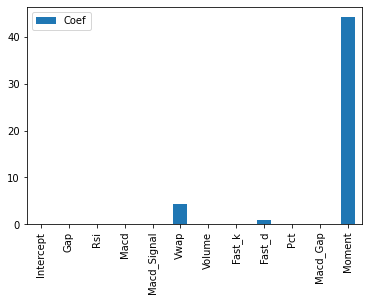

In [49]:
plot_coef(lasso_model['regulator'].coef_, train_X.columns, True)

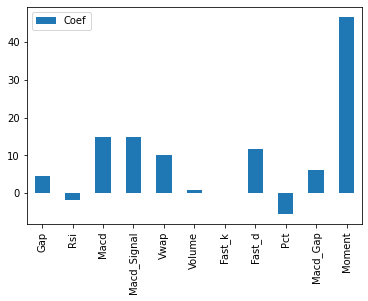

In [50]:
plot_coef(ridge_model['regulator'].coef_, train_X.columns)

In [51]:
r_pred = ridge_model.predict(test_X)
l_pred = lasso_model.predict(test_X)

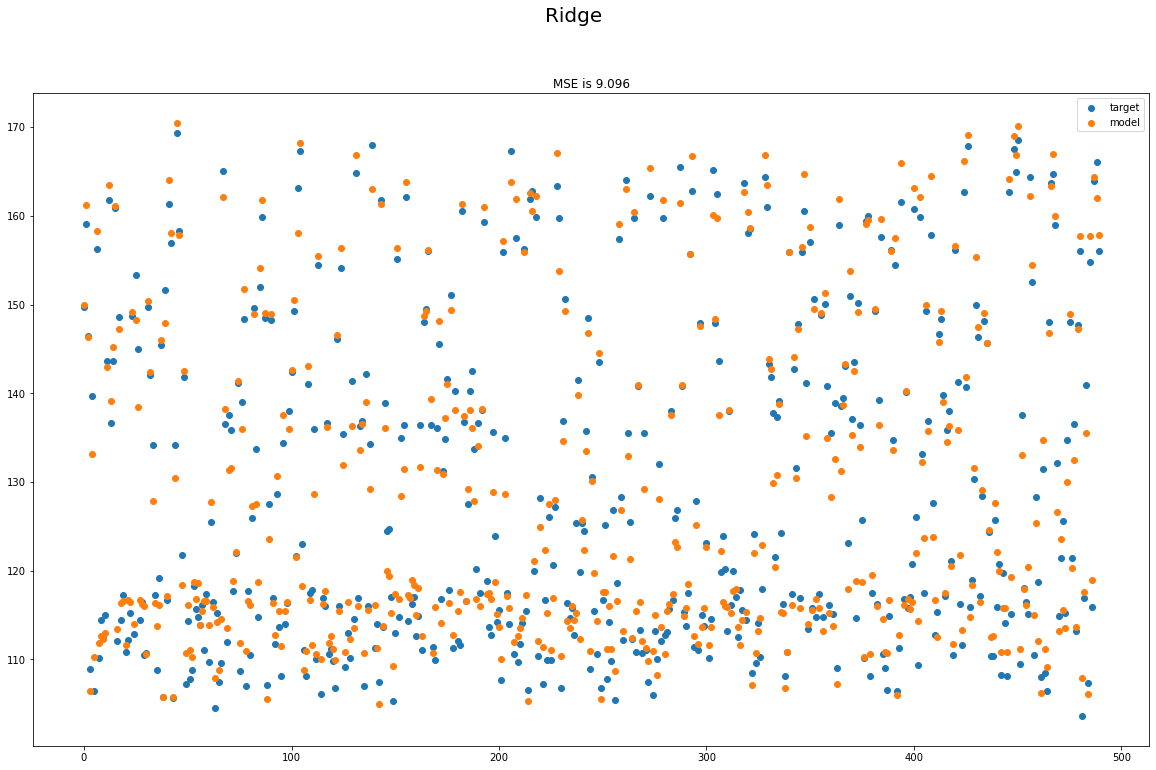

In [56]:
visualize(r_pred, test_y, "Ridge")

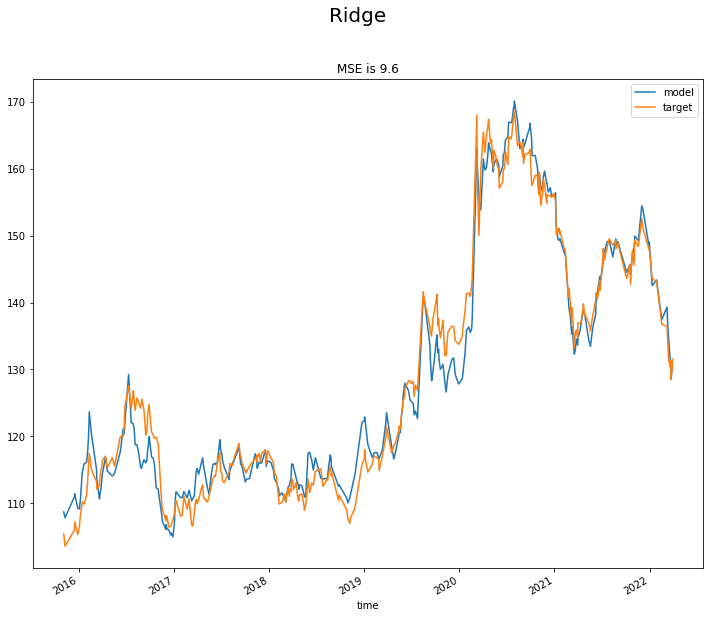

In [57]:
eval_model.visualize_plot(r_pred[-YEAR:], test_y[-YEAR:], "Ridge")


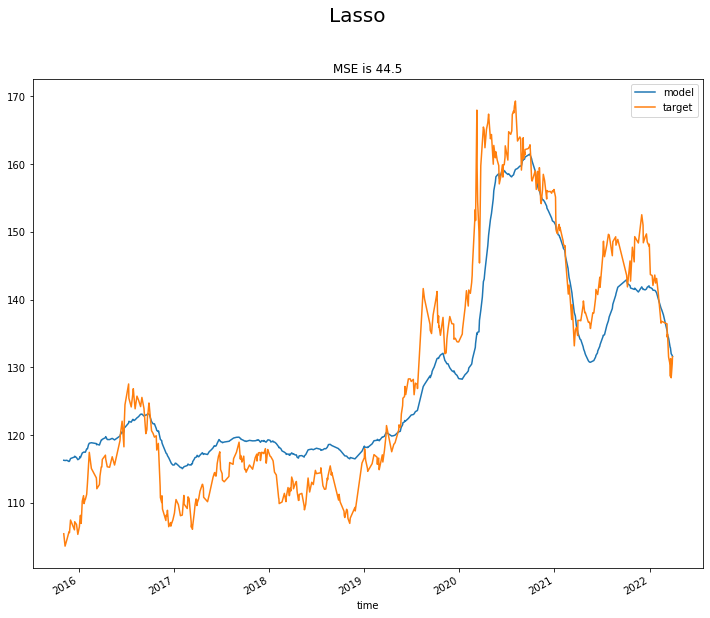

In [58]:
eval_model.visualize_plot(l_pred, test_y, "Lasso")

In [59]:
rf_model.fit(train_X, train_y)
rf_pred = rf_model.predict(test_X)

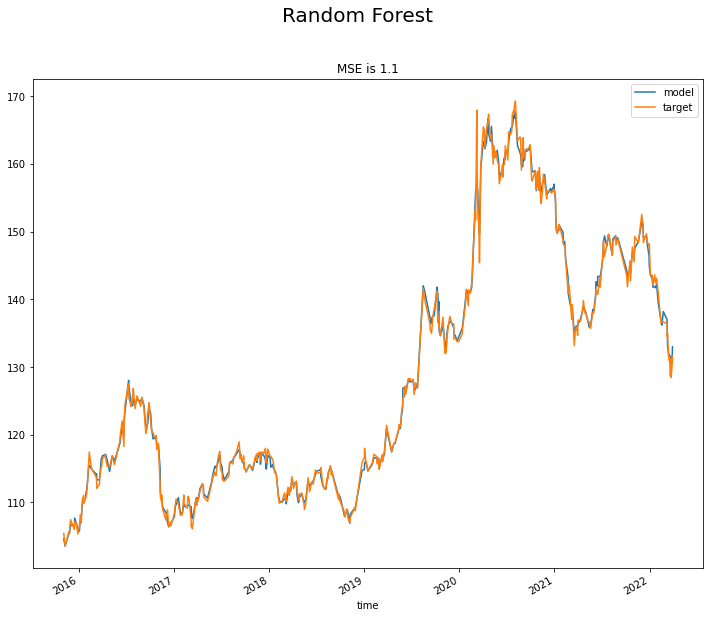

In [60]:
eval_model.visualize_plot(rf_pred, test_y, "Random Forest")

### 모델
* 모델의 성능은 충격적이게도 라쏘가 가장 괜찮은 성능을 보이고 있다. 
* 실상 모맨텀 팩터 하나에만 의지하며 예측을 진행하고 있다.

In [59]:
import joblib
joblib.dump(lasso_model, "Lasso_BTC_only.pkl")
joblib.dump(ridge_model, "Ridge_BTC_only.pkl")

['Ridge_BTC_only.pkl']